# Multi-agent network - collaboration pattern

This notebook is a small experiment of building a multi-agent network using a collaboration pattern in [LangGraph](https://www.langchain.com/langgraph). In this pattern, several agents communicate with each other directly, without the use of a "commander" or a "moderator".

The following diagram shows the agent network structure:

![multi_agent diagram](images/flowchart.png)

This notebook is based on [this LangGraph sample notebook](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/multi-agent-collaboration.ipynb). We upgraded the capability of the chart generator into a coder with a few tweaks and prompt tuning. This small upgrade will enable us to solve a broader range of problems.

## Setup

Install the following packages into your environment, or just `pip install -r requirements.txt`.

In [1]:
# %%capture --no-stderr
# %pip install -U langchain_community langchain_openai langchain_experimental matplotlib langgraph

In [2]:
import os
from typing import Annotated, Literal

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.types import Command

In [3]:
load_dotenv()

True

## Define tools

The researcher will use a (web) search tool called [Tavily](https://tavily.com/), and the coder has a python REPL tool. You will need a `TAVILY_API_KEY` to use the Tavily tool.

In [4]:
tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Model

You will need a model that support tool use natively, such as [gpt-4o](https://openai.com/index/hello-gpt-4o/). You need an API key to use the model. Unfortunately, most of the LLM models are blocked or otherwise not supported in Hong Kong.

It is possible to use weaker models that does not support tool use natively, but then you will need to guide the model clearly (for example, using [ReAct prompting](https://www.promptingguide.ai/techniques/react)), parse the outputs from the model, manually use the tool, and send the tool use result back to the model for each step.

In [5]:
llm = ChatOpenAI(
    base_url=os.getenv("OPENAI_API_ENDPOINT"),
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4o",
    temperature=0,
)

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [6]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [7]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a python coder colleague, who is a specialist in calculations and generating charts."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["coder", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "coder")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Coder agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
coder_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You are a python coder. You can only create and run python codes. You are a specialist in calculations and generating charts."
        " You are working with a researcher colleague."
    ),
)


def coder_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = coder_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="coder"
    )
    return Command(
        update={
            # share internal message history of coder agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph

We can now put it all together and define the graph. Note that we do not need to define edges between the agents since it is handled by the [Command](https://blog.langchain.dev/command-a-new-tool-for-multi-agent-architectures-in-langgraph/) feature.

In [8]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("coder", coder_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

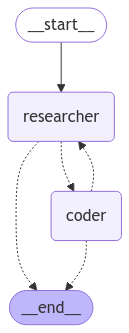

In [9]:
# display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use cases

With the graph created, let's test it on some problems.

### 1. Make a line graph from web data

This is the sample use case given in the LangGraph example, except I ask for more local (Hong Kong) information.

{'researcher': {'messages': [HumanMessage(content="First, get Hong Kong's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='601953f6-01e4-4b02-b9a4-d51eafabf960'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ncS26ovjRto9PK2oXwVPLYel', 'function': {'arguments': '{"query":"Hong Kong GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 219, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_82ce25c0d4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0d7241bf-af32-4f36-b9d8-a9f8cc5d96b1-0', tool_calls=[{'name': 

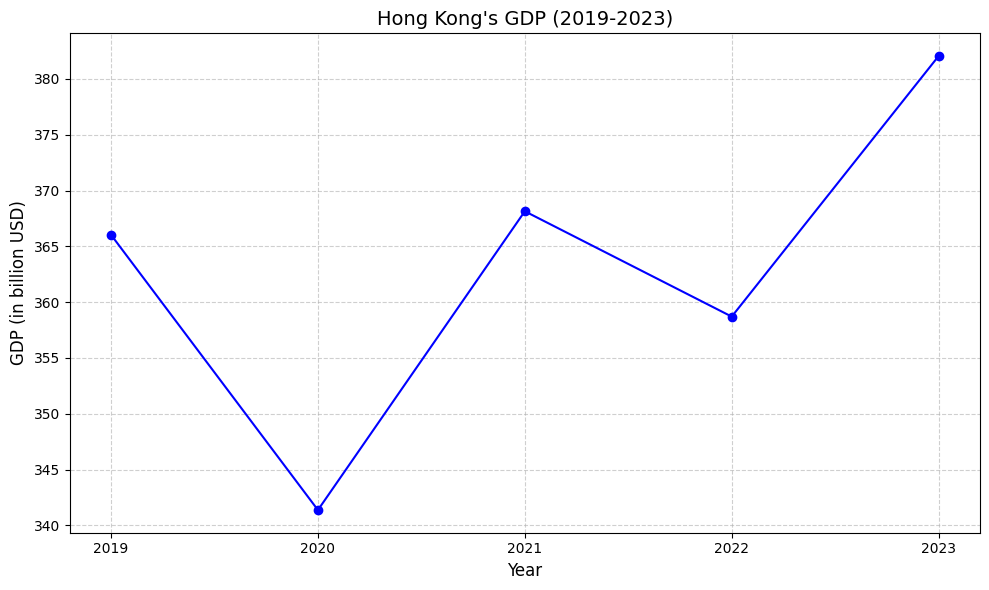

{'coder': {'messages': [HumanMessage(content="First, get Hong Kong's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='601953f6-01e4-4b02-b9a4-d51eafabf960'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ncS26ovjRto9PK2oXwVPLYel', 'function': {'arguments': '{"query":"Hong Kong GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 219, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_82ce25c0d4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0d7241bf-af32-4f36-b9d8-a9f8cc5d96b1-0', tool_calls=[{'name': 'tavi

In [10]:
events1 = []
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get Hong Kong's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
):
    events1.append(s)
    print(s)
    print("----")

In [11]:
for s in events1:
    sender = list(s.keys())[0]
    for message in s[sender]["messages"]:
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

================================ Human Message =================================

First, get Hong Kong's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ncS26ovjRto9PK2oXwVPLYel)
 Call ID: call_ncS26ovjRto9PK2oXwVPLYel
  Args:
    query: Hong Kong GDP past 5 years
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/statistics/316972/hong-kong-gross-domestic-product/", "content": "Premium Statistic Gross domestic product (GDP) growth in Hong Kong 2001-2028 Premium Statistic GDP share of the financial services industry of Hong Kong 2012-2022 Premium Statistic GDP share of the financial services industry Hong Kong 2012-2022, by category Premium Statistic GDP share of the trading and logistics industry Hong Kong 2012-2022 \"Gr

### 2. Calculation from web data

Since we have a coder instead of a chart generator, we can do something with Python that is not chart generation, e.g. do computation.

In [12]:
events2 = []
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of Hong Kong and Singapore, then calculate the geometric average.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
):
    events2.append(s)
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='Find the latest GDP of Hong Kong and Singapore, then calculate the geometric average.', additional_kwargs={}, response_metadata={}, id='b4b5197d-af74-4011-9c67-2ff18042321e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c75jleoJMrDxhy9oPm66wDyl', 'function': {'arguments': '{"query": "latest GDP of Hong Kong 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_xd72wt9RtF6JbeqsSF2GDAZM', 'function': {'arguments': '{"query": "latest GDP of Singapore 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 205, 'total_tokens': 270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fing

In [13]:
for s in events2:
    sender = list(s.keys())[0]
    for message in s[sender]["messages"]:
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

================================ Human Message =================================

Find the latest GDP of Hong Kong and Singapore, then calculate the geometric average.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_c75jleoJMrDxhy9oPm66wDyl)
 Call ID: call_c75jleoJMrDxhy9oPm66wDyl
  Args:
    query: latest GDP of Hong Kong 2023
  tavily_search_results_json (call_xd72wt9RtF6JbeqsSF2GDAZM)
 Call ID: call_xd72wt9RtF6JbeqsSF2GDAZM
  Args:
    query: latest GDP of Singapore 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://countryeconomy.com/gdp/hong-kong", "content": "Hong Kong GDP - Gross Domestic Product 2023 | countryeconomy.com Hong Kong GDP - Gross Domestic Product GDP Hong Kong 2023 Gross Domestic Product of Hong Kong grew 3.2% in 2023 compared to last year. The GDP figure in 2023 was €352,089$382,055 million, Hong Kon